In [1]:
import pandas as pd
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import numpy as np
from scipy.stats import ttest_rel
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource



output_notebook()

Loading BokehJS ...

In [2]:
table =pd.read_csv('baseballcomplete.csv')
table

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,1.32,0.85,-0.85,19.4
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,3,2,5.0,1.0,6.0,1.0,2.82,1.40,-1.40,14.4
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,3,2,5.0,1.0,6.0,1.0,2.37,1.48,-1.48,21.9
3,KC,2024-04-02,80.8,-3.13,5.61,"Rizzo, Anthony",519203,668678,field_out,hit_into_play,...,3,2,5.0,1.0,6.0,1.0,4.61,-0.50,0.50,36.3
4,FF,2024-04-02,95.4,-1.95,5.12,"Hedges, Austin",595978,622491,strikeout,foul_tip,...,3,2,5.0,3.0,6.0,6.0,1.59,1.08,1.08,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701552,FF,2024-10-30,95.6,-2.76,6.15,"Ohtani, Shohei",660271,543037,field_out,hit_into_play,...,1,0,5.0,1.0,NaN,NaN,1.00,0.69,-0.69,41.8
701553,SI,2024-10-30,96.0,-0.72,6.67,"Hernández, Teoscar",606192,605280,NaN,ball,...,1,3,1.0,1.0,NaN,NaN,2.16,1.62,1.62,49.4
701554,FF,2024-10-30,95.8,-1.55,5.85,"Lux, Gavin",666158,596133,NaN,ball,...,1,3,1.0,1.0,NaN,NaN,0.75,0.37,-0.37,49.2
701555,SL,2024-10-30,85.9,2.78,5.53,"Torres, Gleyber",650402,607455,NaN,swinging_strike,...,1,1,2.0,1.0,NaN,NaN,4.06,-0.70,0.70,31.3


In [3]:
for columns in table.columns:
    print(columns)

pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
fielder_2
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignment
spin_axis
delta_home_win_exp
d

In [6]:
no_batspeed =table[table['bat_speed'].isna()]
no_batspeed.description.value_counts()

description
ball                       233158
called_strike              114863
blocked_ball                14841
hit_into_play                7013
foul                         3675
swinging_strike              2710
hit_by_pitch                 1994
swinging_strike_blocked       319
foul_tip                      230
foul_bunt                     124
pitchout                       51
missed_bunt                    23
Name: count, dtype: int64

In [7]:
speed_length = table.dropna(subset = ['bat_speed'])

In [8]:
design = MS(speed_length[['bat_speed','swing_length']])

In [9]:
X = design.fit_transform(speed_length)
y = speed_length.description == "swinging_strike" 

In [10]:
speed_length['bool_swing_strike'] = y

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_6689/4102849706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_length['bool_swing_strike'] = y


In [11]:
table.bat_speed.isna().sum(),table.swing_length.isna().sum()


(379001, 379001)

In [12]:
glm = sm.GLM(y,
             X,
             family = sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-2.2683,0.039,-58.416,0.0
bat_speed,-0.0483,0.001,-88.548,0.0
swing_length,0.5949,0.005,115.709,0.0


In [13]:
graph_speed = speed_length.groupby('bat_speed')['bool_swing_strike'].mean().reset_index()
graph_length = speed_length.groupby('swing_length')['bool_swing_strike'].mean().reset_index()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

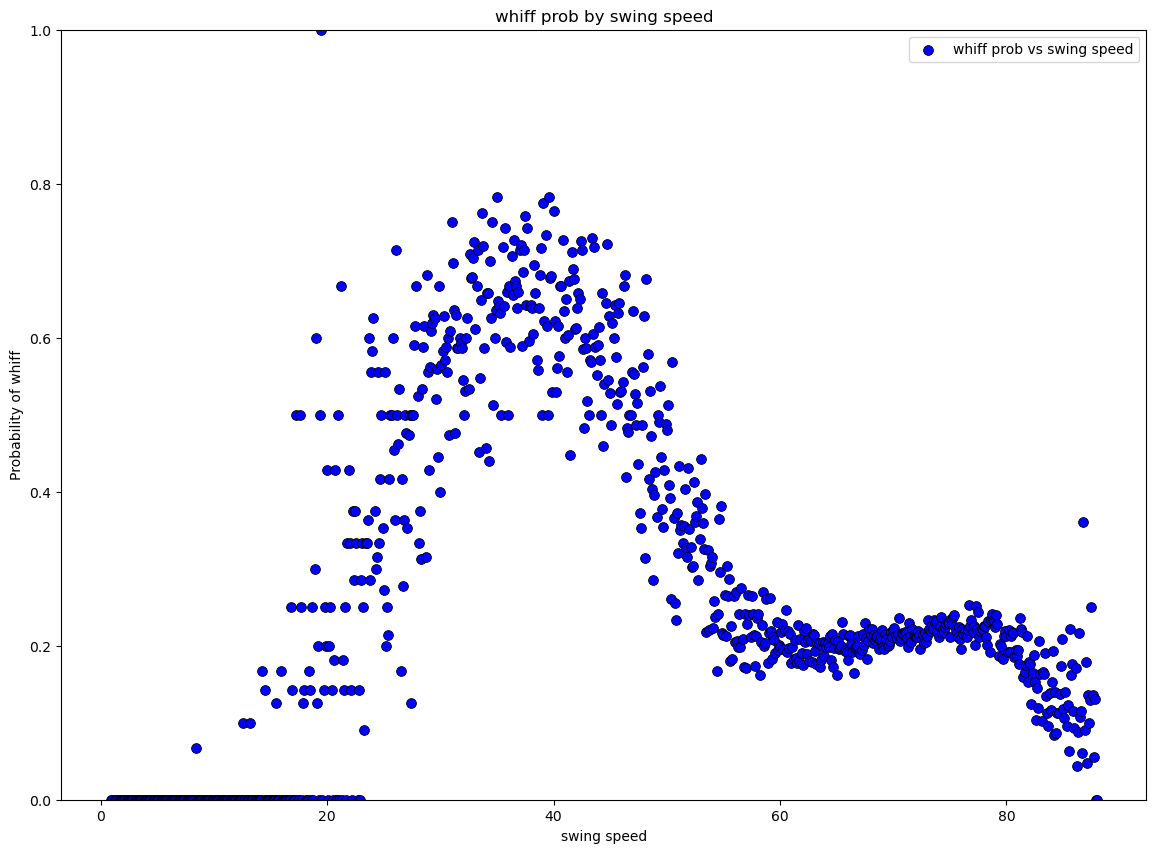

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=graph_speed, x='bat_speed', y='bool_swing_strike', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='whiff prob vs swing speed')
ax.set_title('whiff prob by swing speed')
ax.set_xlabel('swing speed')
ax.set_ylabel('Probability of whiff')
ax.set_ylim(0, 1)
ax.legend()

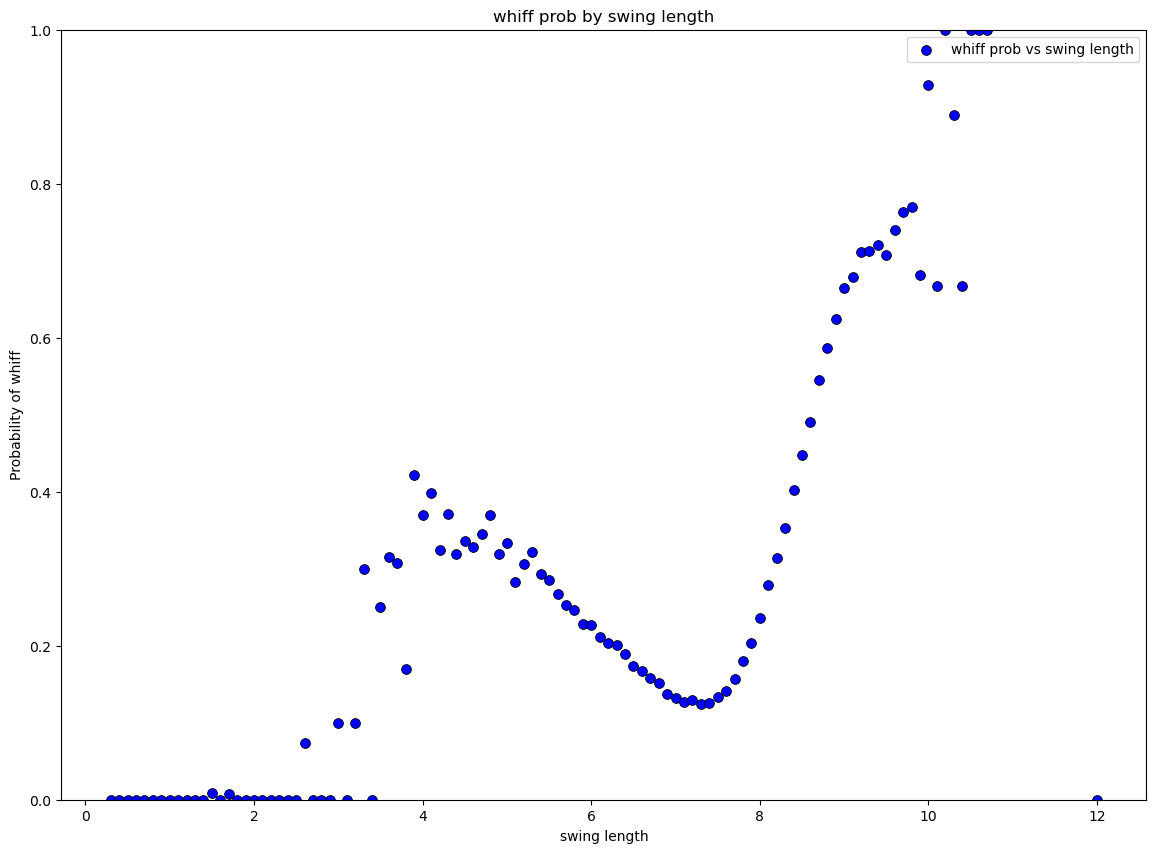

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=graph_length, x='swing_length', y='bool_swing_strike', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='whiff prob vs swing length')
ax.set_title('whiff prob by swing length')
ax.set_xlabel('swing length')
ax.set_ylabel('Probability of whiff')
ax.set_ylim(0, 1)
ax.legend()

In [17]:
protect_plate = table[table['strikes'] == 2]

In [18]:
protect_plate.description.value_counts()

description
ball                       67797
foul                       49226
hit_into_play              46721
swinging_strike            25332
called_strike               9651
blocked_ball                6560
swinging_strike_blocked     2869
foul_tip                    2815
hit_by_pitch                 792
pitchout                      17
foul_bunt                     11
missed_bunt                    3
Name: count, dtype: int64

In [19]:
yfoul = protect_plate.description == 'foul'
yprotectplate = protect_plate.description == 'called_strike'
protect_plate['bool_extendab'] = protect_plate['description'].isin(['ball','foul'])
protect_plate['bool_foul'] = yfoul
protect_plate['bool_look'] = yprotectplate

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_6689/2936379280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protect_plate['bool_extendab'] = protect_plate['description'].isin(['ball','foul'])
/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_6689/2936379280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protect_plate['bool_foul'] = yfoul
/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_6689/2936379280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a 

In [20]:
graph_foul_speed = protect_plate.groupby('bat_speed')['bool_foul'].mean().reset_index()
graph_foul_length = protect_plate.groupby('swing_length')['bool_foul'].mean().reset_index()
graph_look_speed = protect_plate.groupby('bat_speed')['bool_look'].mean().reset_index()
graph_look_length = protect_plate.groupby('swing_length')['bool_look'].mean().reset_index()
graph_extendab_speed = protect_plate.groupby('bat_speed')['bool_extendab'].mean().reset_index()
graph_extendab_length = protect_plate.groupby('swing_length')['bool_extendab'].mean().reset_index()

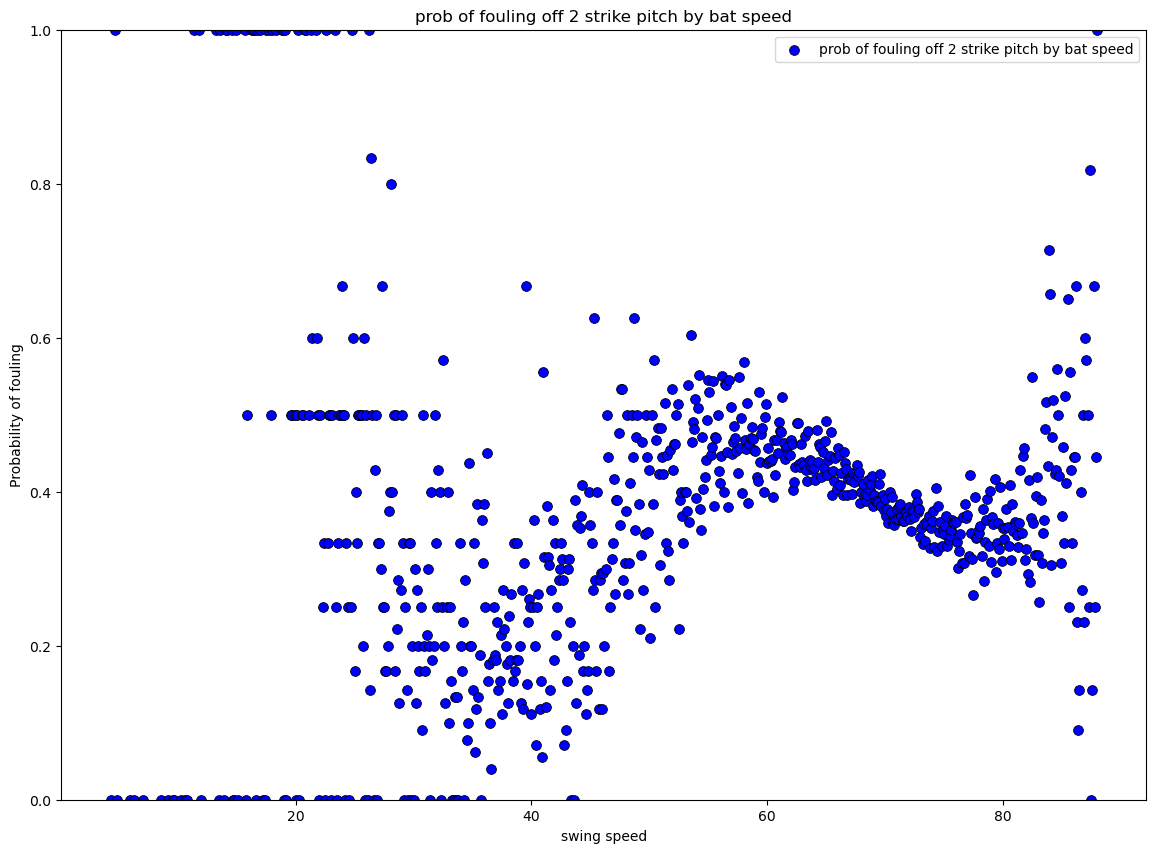

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=graph_foul_speed, x='bat_speed', y='bool_foul', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='prob of fouling off 2 strike pitch by bat speed')
ax.set_title('prob of fouling off 2 strike pitch by bat speed')
ax.set_xlabel('swing speed')
ax.set_ylabel('Probability of fouling')
ax.set_ylim(0, 1)
ax.legend()

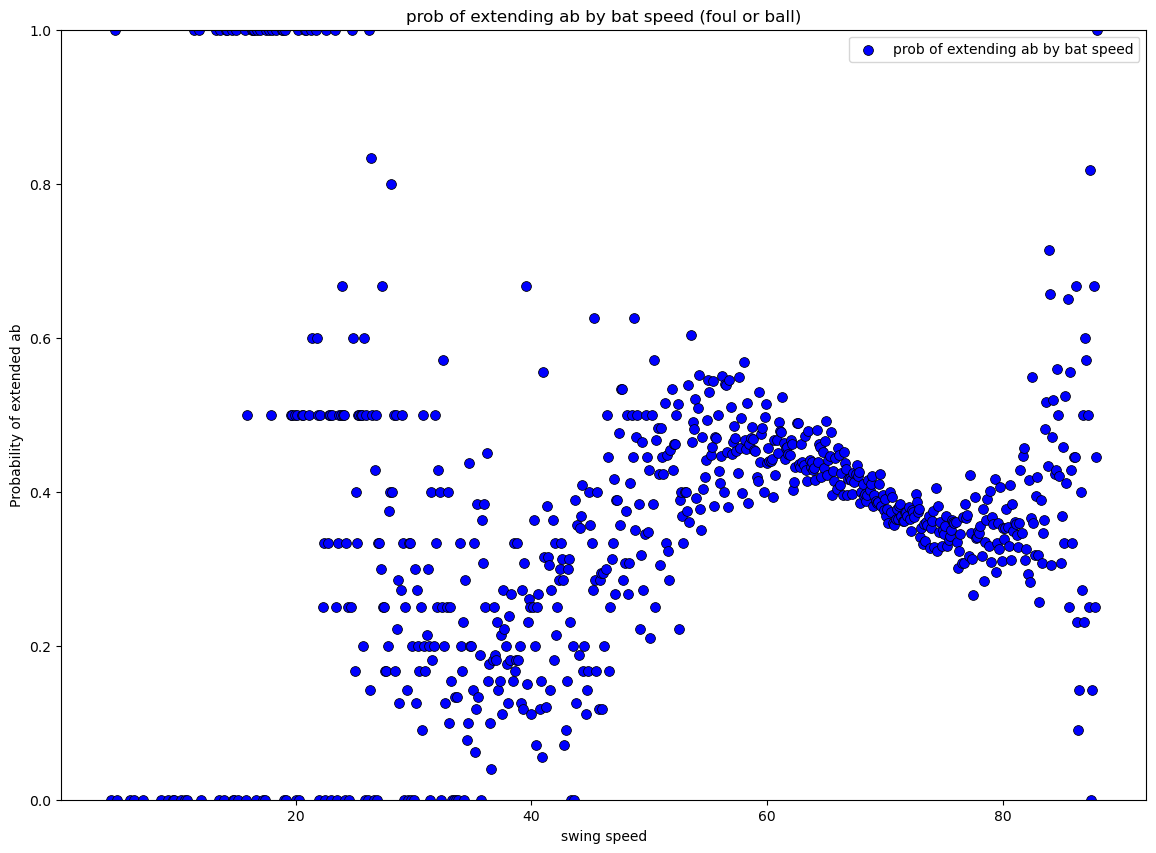

In [22]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=graph_extendab_speed, x='bat_speed', y='bool_extendab', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='prob of extending ab by bat speed')
ax.set_title('prob of extending ab by bat speed (foul or ball)')
ax.set_xlabel('swing speed')
ax.set_ylabel('Probability of extended ab')
ax.set_ylim(0, 1)
ax.legend()

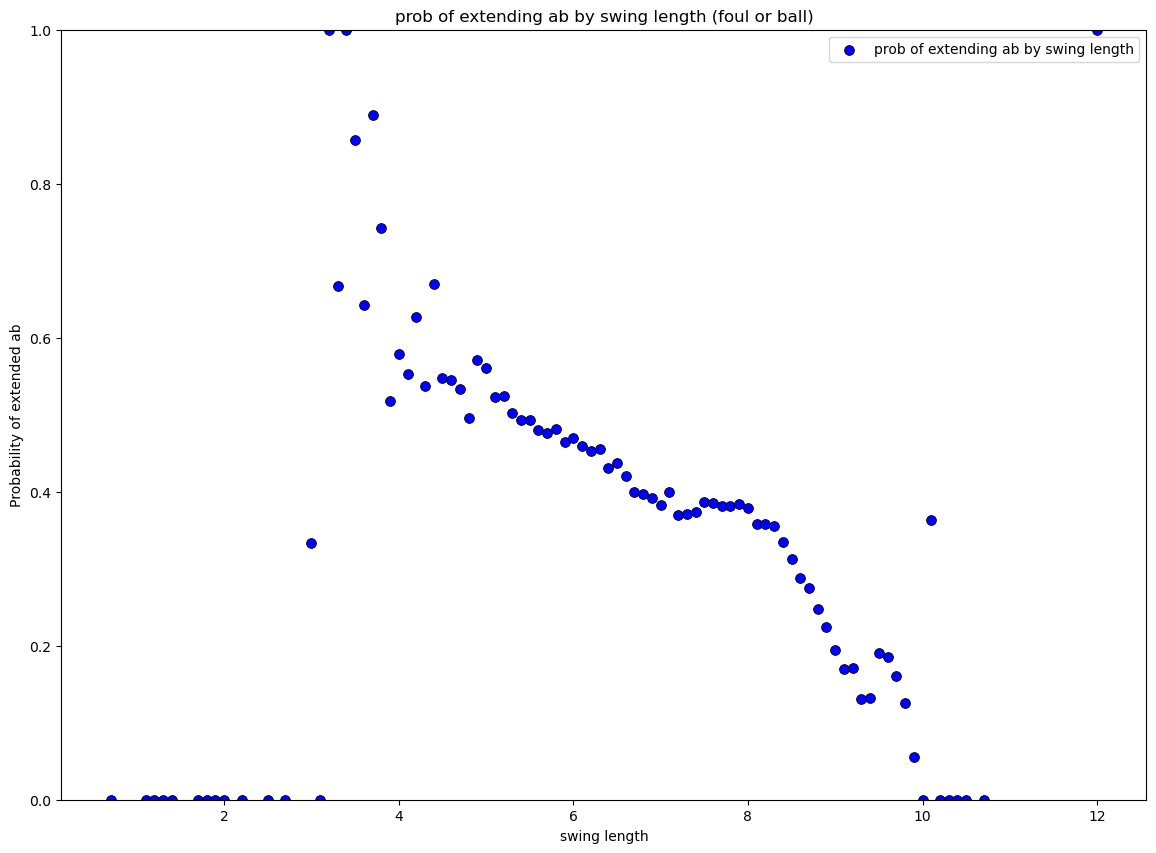

In [23]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=graph_extendab_length, x='swing_length', y='bool_extendab', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='prob of extending ab by swing length')
ax.set_title('prob of extending ab by swing length (foul or ball)')
ax.set_xlabel('swing length')
ax.set_ylabel('Probability of extended ab')
ax.set_ylim(0, 1)
ax.legend()

In [24]:
table.events.value_counts()

events
field_out                    73078
strikeout                    40569
single                       25577
walk                         14220
double                        7668
home_run                      5397
force_out                     3432
grounded_into_double_play     3176
hit_by_pitch                  1994
sac_fly                       1230
field_error                   1091
triple                         682
sac_bunt                       454
fielders_choice                381
double_play                    337
truncated_pa                   318
fielders_choice_out            306
strikeout_double_play          110
catcher_interf                  97
sac_fly_double_play             11
triple_play                      2
Name: count, dtype: int64

In [25]:
table['strike'] = table['description'].isin(['called_strike','swinging_strike'])

In [26]:
batterswingspeed = table.groupby('player_name')[['bat_speed','strike','swing_length']].mean().reset_index()

In [27]:
source = ColumnDataSource(data=dict(
    swing_speed=batterswingspeed['bat_speed'],
    whiffperc=batterswingspeed['strike'],
    batter=batterswingspeed['player_name'],
    swinglength = batterswingspeed['swing_length']
))

p = figure(height=400, width=600, title="strike% by each batter avg swing speed",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Speed", y_axis_label="Strike %")

p.scatter('swing_speed', 'whiffperc', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"), ("Strike %", "@whiffperc")]
p.add_tools(hover)

show(p)

In [28]:
source = ColumnDataSource(data=dict(
    swing_speed=batterswingspeed['bat_speed'],
    whiffperc=batterswingspeed['strike'],
    batter=batterswingspeed['player_name'],
    swinglength = batterswingspeed['swing_length']
))

p = figure(height=400, width=600, title="strike% by each batter avg swing length",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Length", y_axis_label="Strike %")

p.scatter('swinglength', 'whiffperc', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"), ("Strike %", "@whiffperc")]
p.add_tools(hover)

show(p)

In [29]:
protect_plate = table[table['strikes'] == 2]

In [30]:
protect_plate['bool_extendab'] = protect_plate['description'].isin(['ball','foul'])

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_6689/3713932281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protect_plate['bool_extendab'] = protect_plate['description'].isin(['ball','foul'])


In [31]:
batterswingspeed2s = protect_plate.groupby('player_name')[['bat_speed','strike','swing_length','bool_extendab']].mean().reset_index()

In [32]:
source = ColumnDataSource(data=dict(
    extendab_prob = batterswingspeed2s['bool_extendab'],
    swing_speed=batterswingspeed2s['bat_speed'],
    whiffperc=batterswingspeed2s['strike'],
    batter=batterswingspeed2s['player_name'],
    swinglength = batterswingspeed2s['swing_length']
))

p = figure(height=400, width=600, title="extend ab prob by each batter avg swing speed",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Speed", y_axis_label="foul or ball prob")

p.scatter('swing_speed', 'extendab_prob', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"), ("Strike %", "@whiffperc")]
p.add_tools(hover)

show(p)

In [33]:
source = ColumnDataSource(data=dict(
    extendab_prob = batterswingspeed2s['bool_extendab'],
    swing_speed=batterswingspeed2s['bat_speed'],
    whiffperc=batterswingspeed2s['strike'],
    batter=batterswingspeed2s['player_name'],
    swinglength = batterswingspeed2s['swing_length']
))

p = figure(height=400, width=600, title="extend ab prob by each batter avg swing speed",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Speed", y_axis_label="foul or ball prob")

p.scatter('swinglength', 'extendab_prob', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"), ("Strike %", "@whiffperc")]
p.add_tools(hover)

show(p)

In [34]:
table['outzone'] = table['zone'].isin([11.0,12.0,13.0,14.0]) & table['description'].isin(['swinging_strike'])

In [35]:
batterchase = table.groupby('player_name')[['bat_speed','outzone','swing_length']].mean().reset_index()

In [36]:
source = ColumnDataSource(data=dict(
    swing_speed=batterchase['bat_speed'],
    batter=batterchase['player_name'],
    swinglength = batterchase['swing_length'],
    chaseprob = batterchase['outzone']
))

p = figure(height=400, width=600, title="chase prob by swing length",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Length", y_axis_label="chase prob")

p.scatter('swinglength', 'chaseprob', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength")]
p.add_tools(hover)

show(p)

In [37]:
source = ColumnDataSource(data=dict(
    swing_speed=batterchase['bat_speed'],
    batter=batterchase['player_name'],
    swinglength = batterchase['swing_length'],
    chaseprob = batterchase['outzone']
))

p = figure(height=400, width=600, title="chase prob by swing length",
           tools="pan,box_zoom,reset,save", x_axis_label="Avg Swing Length", y_axis_label="chase prob")

p.scatter('swing_speed', 'chaseprob', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Batter", "@batter"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"),("Chase Prob","@chaseprob")]
p.add_tools(hover)

show(p)

In [38]:
table.on_1b.isna().sum()

489108

In [39]:
strikes = table.groupby('strikes')[['bat_speed','swing_length']].mean().reset_index()

<Axes: xlabel='strikes', ylabel='bat_speed'>

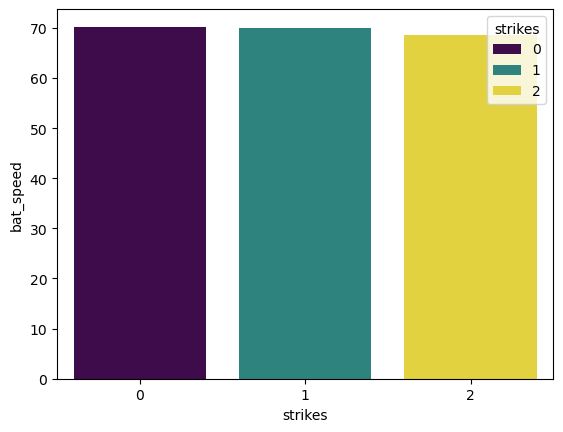

In [40]:
sns.barplot(data=strikes, x='strikes', y='bat_speed',hue = 'strikes', palette='viridis')

<Axes: xlabel='strikes', ylabel='swing_length'>

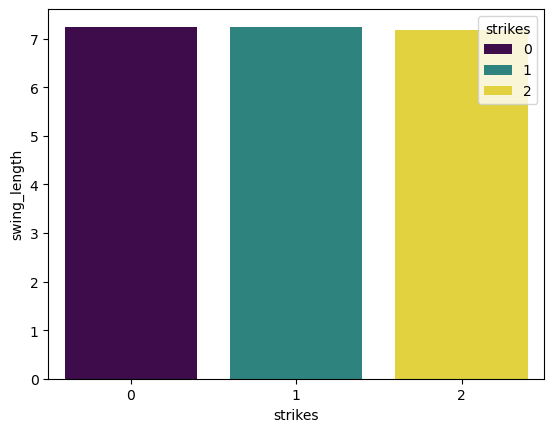

In [41]:
sns.barplot(data=strikes, x='strikes', y='swing_length',hue = 'strikes', palette='viridis')

In [42]:
table['bool_1st'] = table['on_1b'].notna()
table['bool_2nd'] = table['on_2b'].notna()
table['bool_3rd'] = table['on_3b'].notna()
table['base_state'] = list(zip(table['bool_1st'],table['bool_2nd'],table['bool_3rd'],table['outs_when_up']))

In [43]:
table.base_state.value_counts()

base_state
(False, False, False, 0)    172808
(False, False, False, 1)    128080
(False, False, False, 2)    102945
(True, False, False, 2)      47307
(True, False, False, 1)      46571
(True, False, False, 0)      37353
(False, True, False, 2)      24356
(True, True, False, 2)       20873
(False, True, False, 1)      18343
(True, True, False, 1)       16508
(False, True, False, 0)      12121
(False, False, True, 2)       9706
(True, False, True, 2)        9455
(True, True, False, 0)        9453
(True, True, True, 2)         7137
(True, False, True, 1)        6718
(False, True, True, 2)        6603
(False, False, True, 1)       5807
(True, True, True, 1)         5352
(False, True, True, 1)        4981
(True, False, True, 0)        3202
(True, True, True, 0)         2520
(False, True, True, 0)        2117
(False, False, True, 0)       1241
Name: count, dtype: int64

In [44]:
all_situations = table.groupby(['base_state','strikes'])[['bat_speed','swing_length']].mean().reset_index()

/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 



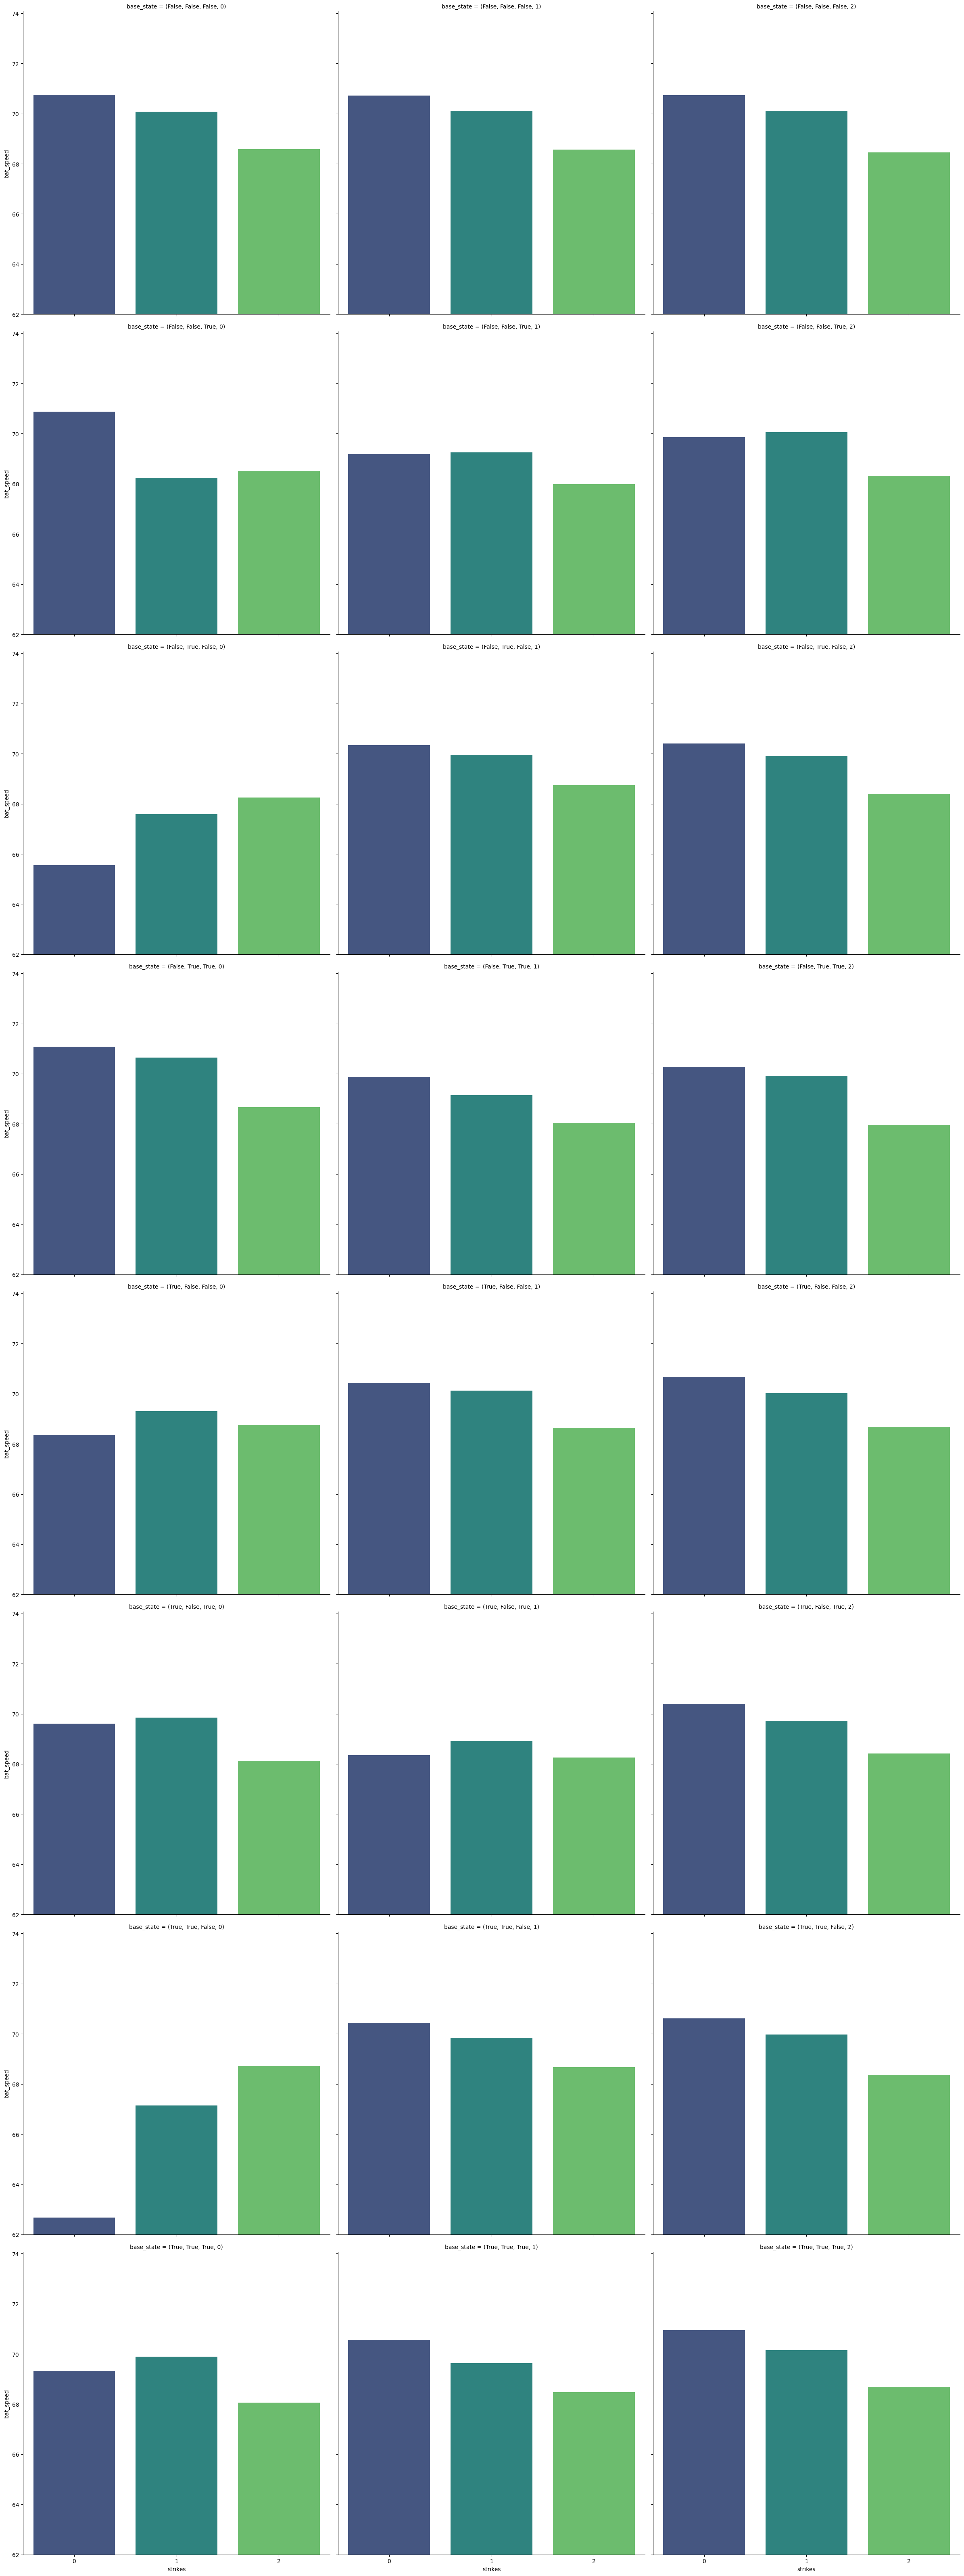

In [45]:
g = sns.FacetGrid(all_situations, col='base_state', col_wrap=3, height=8, sharey=True)
g.map(sns.barplot, 'strikes', 'bat_speed', order=sorted(all_situations['strikes'].unique()), palette='viridis',legend = False)
g.set(ylim=(62, all_situations['bat_speed'].max() + 3))

/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/anaconda3/envs/stat4255/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 



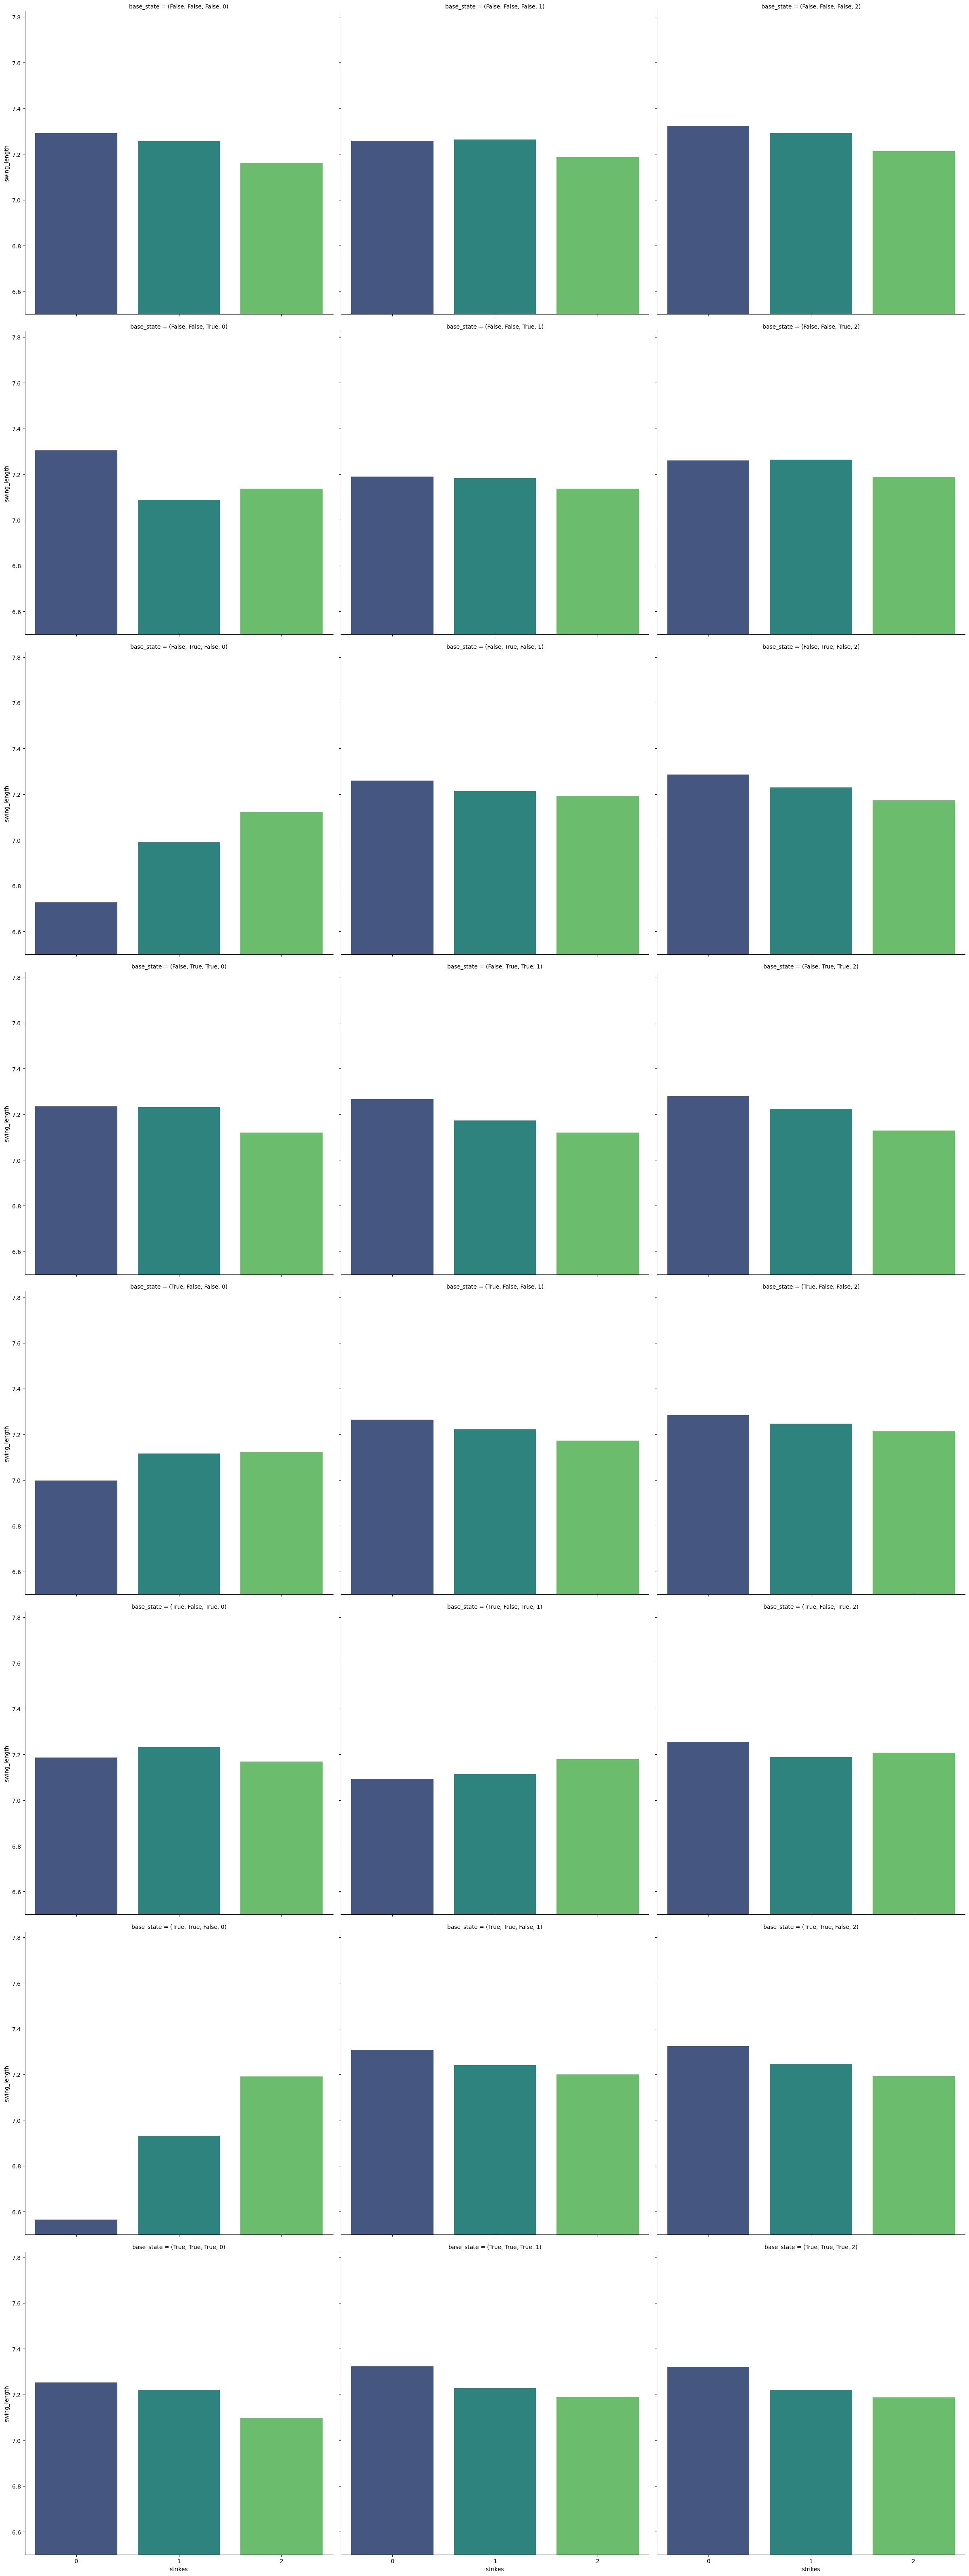

In [46]:
g = sns.FacetGrid(all_situations, col='base_state', col_wrap=3, height=8, sharey=True)
g.map(sns.barplot, 'strikes', 'swing_length', order=sorted(all_situations['strikes'].unique()), palette='viridis',legend = False)
g.set(ylim=(6.5, all_situations['swing_length'].max() + 0.5))

In [47]:
pitchers = table.groupby('pitcher')[['bat_speed','swing_length','release_speed','release_spin_rate']].mean().reset_index()

In [48]:
pitchersimple = table.groupby('release_speed')[['bat_speed']].mean()
pitcherspin = table.groupby('release_spin_rate')[['swing_length']].mean()
pitcherspin = pitcherspin.dropna()

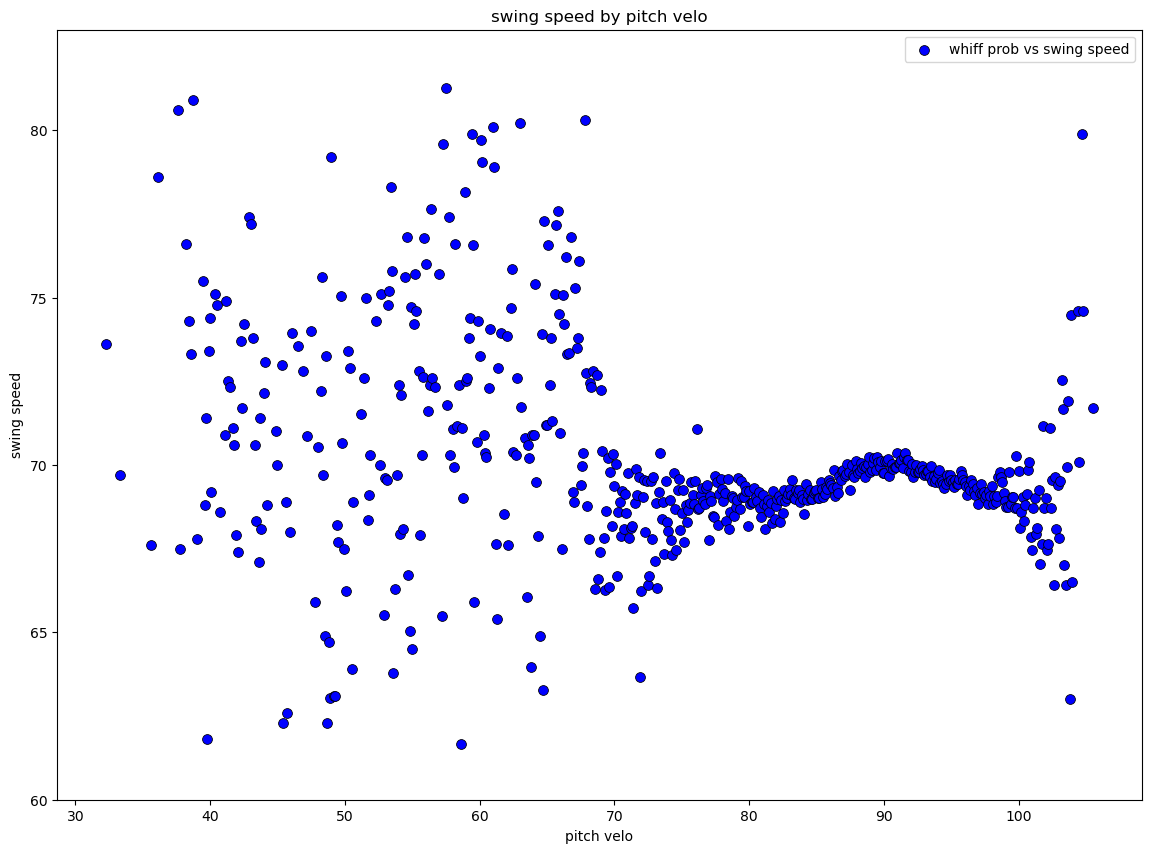

In [49]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=pitchersimple, x='release_speed', y='bat_speed', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='whiff prob vs swing speed')
ax.set_title('swing speed by pitch velo')
ax.set_xlabel('pitch velo')
ax.set_ylabel('swing speed')
ax.set_ylim(60, 83)
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


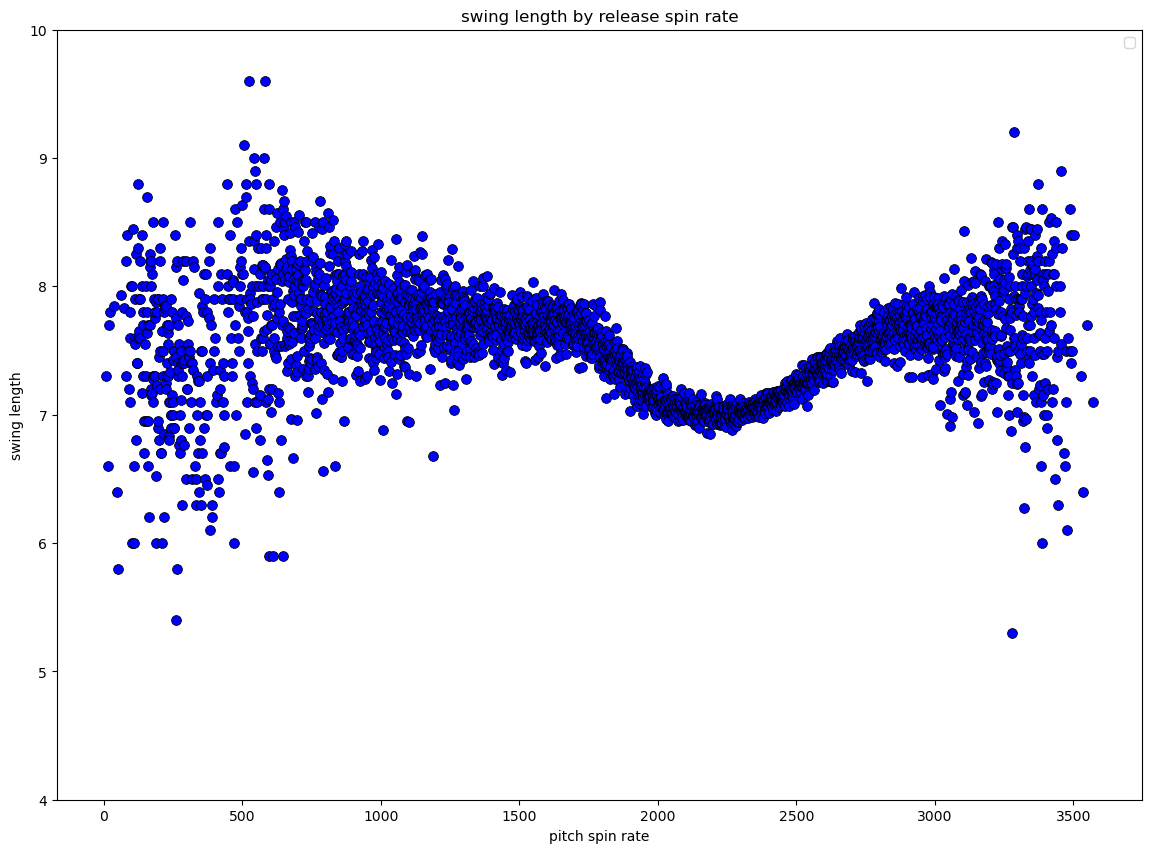

In [50]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(data=pitcherspin, x='release_spin_rate', y='swing_length', 
                    ax=ax, color='blue', edgecolor='k', s=50)
ax.set_title('swing length by release spin rate')
ax.set_xlabel('pitch spin rate')
ax.set_ylabel('swing length')
ax.set_ylim(4, 10)
ax.legend()

In [51]:
source = ColumnDataSource(data=dict(
    swing_speed=pitchers['bat_speed'],
    pitcher=pitchers['pitcher'],
    pitch_velo=pitchers['release_speed'],
    swinglength = pitchers['swing_length'],
    spin_rate = pitchers['release_spin_rate']
))

p = figure(height=400, width=600, title="pitch velo vs bat speed",
           tools="pan,box_zoom,reset,save", x_axis_label="pitch velo", y_axis_label="swing speed")

p.scatter('pitch_velo', 'swing_speed', size=10, color="#69BE28", alpha=0.5, source=source)

hover = HoverTool()
hover.tooltips = [("Pitcher", "@pitcher"), ("Avg swing speed", "@swing_speed"),("Avg swing length", "@swinglength"), ("Pitch Speed", "@pitch_velo"),("Spin Rate","spin_rate")]
p.add_tools(hover)

show(p)

# Seems there isn't a clear correlation between speed of pitch thrown and bat speed

In [52]:
table.release_spin_rate

0         2061.0
1         1677.0
2         1832.0
3         2479.0
4         2153.0
           ...  
701552    2458.0
701553    2341.0
701554    2548.0
701555    2426.0
701556    1209.0
Name: release_spin_rate, Length: 701557, dtype: float64

In [53]:
pitch_effect = table.groupby('pitch_type')[['bat_speed','swing_length']].mean().reset_index()

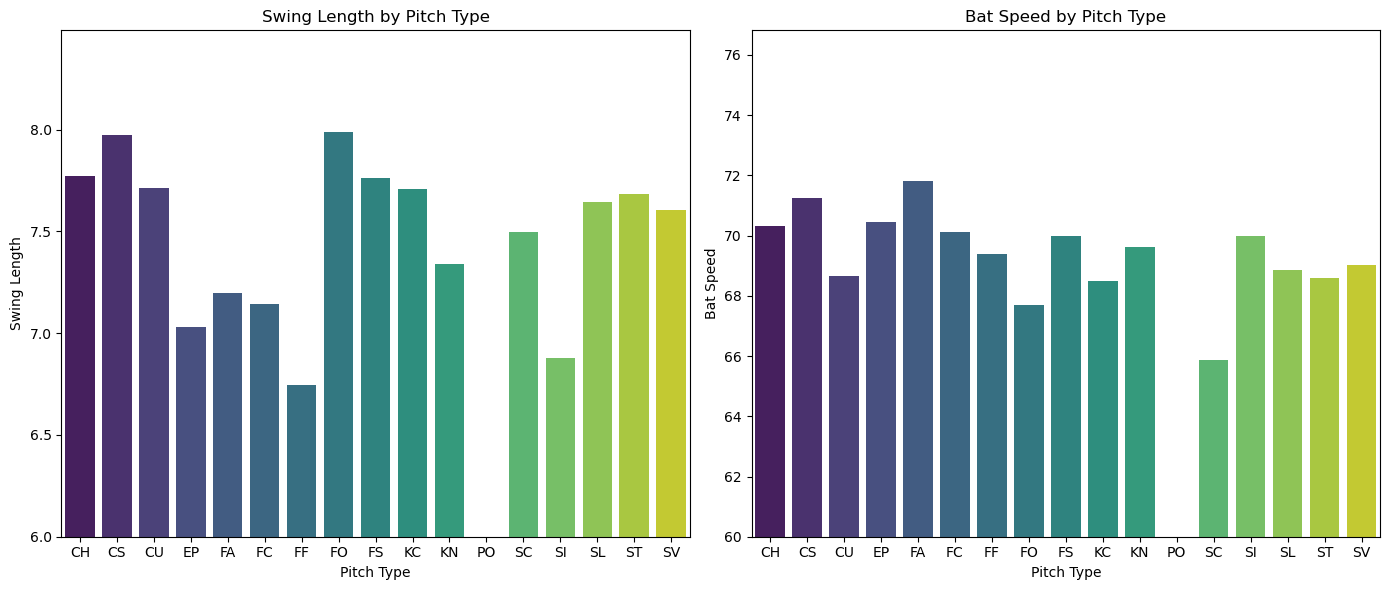

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
sns.barplot(data=pitch_effect, x='pitch_type', y='swing_length', 
            hue='pitch_type', palette='viridis', ax=axes[0])
axes[0].set_ylim(6,pitch_effect['swing_length'].max()+0.5)
axes[0].set_title("Swing Length by Pitch Type")
axes[0].set_xlabel("Pitch Type")
axes[0].set_ylabel("Swing Length")
sns.barplot(data=pitch_effect, x='pitch_type', y='bat_speed', 
            hue='pitch_type', palette='viridis', ax=axes[1])
axes[1].set_ylim(60,pitch_effect['bat_speed'].max()+5)
axes[1].set_title("Bat Speed by Pitch Type")
axes[1].set_xlabel("Pitch Type")
axes[1].set_ylabel("Bat Speed")
plt.tight_layout()
plt.show()

In [55]:
len(table.pitch_type.value_counts())

17

In [56]:
avg_swingspeed_swinglength = table.groupby('player_name')[['bat_speed','swing_length']].mean().reset_index()
avg_swingspeed_swinglength

,player_name,bat_speed,swing_length
0,"Abrams, CJ",69.809306,7.389728
1,"Abreu, José",71.169492,6.983051
2,"Abreu, Wilyer",72.746356,7.313023
3,"Acuña Jr., Ronald",74.649441,7.511453
4,"Acuña, Luisangel",71.421519,7.187342
...,...,...,...
646,"Yorke, Nick",70.154667,7.164000
647,"Yoshida, Masataka",69.532586,7.212556
648,"Young, Jacob",62.357464,6.467299
649,"Zavala, Seby",65.936000,7.188000


In [57]:
overall_averages = (
    table.groupby('player_name')[['bat_speed', 'swing_length']]
    .mean()
    .rename(columns={'bat_speed': 'overall_bat_speed', 'swing_length': 'overall_swing_length'})
    .reset_index()
)
pitch_type_averages = (
    table.groupby(['player_name', 'pitch_type'])[['bat_speed', 'swing_length']]
    .mean()
    .reset_index()
)
whateva= pitch_type_averages.merge(overall_averages, on='player_name')
whateva

,player_name,pitch_type,bat_speed,swing_length,overall_bat_speed,overall_swing_length
0,"Abrams, CJ",CH,71.909630,7.857037,69.809306,7.389728
1,"Abrams, CJ",CU,67.669565,7.820652,69.809306,7.389728
2,"Abrams, CJ",FC,71.382192,7.419178,69.809306,7.389728
3,"Abrams, CJ",FF,69.423676,6.843925,69.809306,7.389728
4,"Abrams, CJ",FS,71.594030,7.940299,69.809306,7.389728
...,...,...,...,...,...,...
6778,"d'Arnaud, Travis",KN,78.900000,8.250000,70.029146,7.717588
6779,"d'Arnaud, Travis",SI,70.632824,7.483206,70.029146,7.717588
6780,"d'Arnaud, Travis",SL,70.925974,8.170130,70.029146,7.717588
6781,"d'Arnaud, Travis",ST,69.831667,8.246667,70.029146,7.717588


In [58]:
whateva = whateva.dropna()

In [59]:
ttest_rel(whateva['bat_speed'],whateva['overall_bat_speed'])

TtestResult(statistic=-2.3604858093626646, pvalue=0.018280940248908677, df=6379)

In [60]:
ttest_rel(whateva['swing_length'],whateva['overall_swing_length'])

TtestResult(statistic=32.6759444692739, pvalue=1.1152386606074984e-216, df=6379)

# This shows you can significantly manipulate a batter's swing length and bat speed depending on pitch type

In [61]:
table.release_spin_rate

0         2061.0
1         1677.0
2         1832.0
3         2479.0
4         2153.0
           ...  
701552    2458.0
701553    2341.0
701554    2548.0
701555    2426.0
701556    1209.0
Name: release_spin_rate, Length: 701557, dtype: float64

In [62]:
table.head(10)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,strike,outzone,bool_1st,bool_2nd,bool_3rd,base_state
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,1.32,0.85,-0.85,19.4,False,False,True,False,False,"(True, False, False, 2)"
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,2.82,1.40,-1.40,14.4,False,False,True,False,False,"(True, False, False, 2)"
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,2.37,1.48,-1.48,21.9,True,False,True,False,False,"(True, False, False, 2)"
3,KC,2024-04-02,80.8,-3.13,5.61,"Rizzo, Anthony",519203,668678,field_out,hit_into_play,...,4.61,-0.50,0.50,36.3,False,False,True,False,False,"(True, False, False, 2)"
4,FF,2024-04-02,95.4,-1.95,5.12,"Hedges, Austin",595978,622491,strikeout,foul_tip,...,1.59,1.08,1.08,17.5,False,False,True,False,False,"(True, False, False, 1)"
5,SI,2024-04-02,90.7,-1.26,5.13,"Ohtani, Shohei",660271,657277,walk,ball,...,2.71,1.45,-1.45,27.9,False,False,True,False,False,"(True, False, False, 2)"
6,SI,2024-04-02,91.8,1.75,4.89,"Casas, Triston",671213,622072,walk,ball,...,1.71,0.93,0.93,23.9,False,False,False,False,False,"(False, False, False, 0)"
7,SI,2024-04-02,94.0,-1.90,4.99,"Hedges, Austin",595978,622491,NaN,called_strike,...,2.17,1.60,1.60,15.0,True,False,True,False,False,"(True, False, False, 1)"
8,SI,2024-04-02,89.9,-1.14,5.01,"Ohtani, Shohei",660271,657277,NaN,ball,...,2.79,1.45,-1.45,24.9,False,False,True,False,False,"(True, False, False, 2)"
9,FF,2024-04-02,93.4,-3.17,5.63,"Rizzo, Anthony",519203,668678,NaN,ball,...,1.12,0.59,-0.59,40.0,False,False,True,False,False,"(True, False, False, 2)"


In [63]:
table['bool_hit'] = ((table['description'] == 'hit_into_play') & (table['events'].isin(['single','double','triple','home_run'])))

In [64]:
success_rates = (
    table.groupby(['player_name', 'pitch_type'])
    .agg(hits=('bool_hit', 'sum'), total_pitches=('bool_hit', 'count'))
    .reset_index()
)
success_rates['hit_rate'] = success_rates['hits'] / success_rates['total_pitches']
best_pitch = success_rates.loc[
    success_rates.groupby('player_name')['hit_rate'].idxmax()
]
best_pitch = best_pitch[['player_name', 'pitch_type']].rename(columns={'pitch_type': 'batter_best_pitch'})
table = table.merge(best_pitch, on='player_name', how='left')

In [65]:
pitch_counts = table.groupby(['pitcher', 'pitch_type']).size().reset_index(name='pitch_count')
pitcher_fav_pitch = pitch_counts.loc[pitch_counts.groupby('pitcher')['pitch_count'].idxmax()]
pitcher_fav_pitch = pitcher_fav_pitch[['pitcher', 'pitch_type']].rename(columns={'pitch_type': 'pitcher_fav_pitch'})
table = table.merge(pitcher_fav_pitch, on='pitcher', how='left')


In [66]:
table

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,arm_angle,strike,outzone,bool_1st,bool_2nd,bool_3rd,base_state,bool_hit,batter_best_pitch,pitcher_fav_pitch
0,FF,2024-04-02,95.0,-2.01,5.22,"Rocchio, Brayan",677587,622491,single,hit_into_play,...,19.4,False,False,True,False,False,"(True, False, False, 2)",True,SI,FF
1,CH,2024-04-02,88.5,-2.09,4.95,"Rocchio, Brayan",677587,622491,NaN,foul,...,14.4,False,False,True,False,False,"(True, False, False, 2)",False,SI,FF
2,SI,2024-04-02,95.0,-2.02,5.12,"Rocchio, Brayan",677587,622491,NaN,called_strike,...,21.9,True,False,True,False,False,"(True, False, False, 2)",False,SI,FF
3,KC,2024-04-02,80.8,-3.13,5.61,"Rizzo, Anthony",519203,668678,field_out,hit_into_play,...,36.3,False,False,True,False,False,"(True, False, False, 2)",False,ST,FF
4,FF,2024-04-02,95.4,-1.95,5.12,"Hedges, Austin",595978,622491,strikeout,foul_tip,...,17.5,False,False,True,False,False,"(True, False, False, 1)",False,FS,FF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701552,FF,2024-10-30,95.6,-2.76,6.15,"Ohtani, Shohei",660271,543037,field_out,hit_into_play,...,41.8,False,False,False,False,False,"(False, False, False, 0)",False,FA,FF
701553,SI,2024-10-30,96.0,-0.72,6.67,"Hernández, Teoscar",606192,605280,NaN,ball,...,49.4,False,False,True,False,False,"(True, False, False, 2)",False,SV,SI
701554,FF,2024-10-30,95.8,-1.55,5.85,"Lux, Gavin",666158,596133,NaN,ball,...,49.2,False,False,True,True,True,"(True, True, True, 0)",False,FC,FF
701555,SL,2024-10-30,85.9,2.78,5.53,"Torres, Gleyber",650402,607455,NaN,swinging_strike,...,31.3,True,True,True,False,False,"(True, False, False, 1)",False,FA,FF


In [67]:
table['is_fav_pitch'] = table['pitch_type'] == table['pitcher_fav_pitch']
fav_pitch_reg = table.is_fav_pitch.mean()

In [68]:
clash = table[table['pitcher_fav_pitch']== table['batter_best_pitch']]
fav_pitch_good = clash.is_fav_pitch.mean()

In [69]:
props = [fav_pitch_reg,fav_pitch_good]
ns = [len(table),len(clash)]
z_stat, p_value = proportions_ztest(props,ns)
p_value

0.0565726414411383

In [70]:
success_ratesp = (
    table.groupby(['player_name', 'zone'])
    .agg(hitsp=('bool_hit', 'sum'), total_pitchesp=('bool_hit', 'count'))
    .reset_index()
)
success_ratesp['hit_ratep'] = success_ratesp['hitsp'] / success_ratesp['total_pitchesp']
best_pitchp = success_ratesp.loc[
    success_ratesp.groupby('player_name')['hit_ratep'].idxmax()
]
best_pitchp = best_pitchp[['player_name', 'zone']].rename(columns={'zone': 'batter_best_zone'})
table = table.merge(best_pitchp, on='player_name', how='left')

In [72]:
pitch_countsp = table.groupby(['pitcher', 'zone']).size().reset_index(name='pitch_count')
pitcher_fav_zone = pitch_countsp.loc[pitch_countsp.groupby('pitcher')['pitch_count'].idxmax()]
pitcher_fav_zone = pitcher_fav_zone[['pitcher', 'zone']].rename(columns={'zone': 'pitcher_fav_zone'})
table = table.merge(pitcher_fav_zone, on='pitcher', how='left')

In [77]:
table['is_fav_zone'] = table['zone'] == table['pitcher_fav_zone']
fav_zone_reg = table.is_fav_zone.mean()
fav_zone_reg

0.21510155268923267

In [78]:
clash_zone = table[table['pitcher_fav_zone']== table['batter_best_zone']]
fav_zone_good = clash_zone.is_fav_zone.mean()
fav_zone_good

0.17857142857142858

In [76]:
props_zone = [fav_zone_reg,fav_zone_good]
ns_zone = [len(table),len(clash_zone)]
z_statz, p_valuez = proportions_ztest(props_zone,ns_zone)
p_valuez

4.236259098947972e-149

In [82]:
clash_zone

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,bool_2nd,bool_3rd,base_state,bool_hit,batter_best_pitch,pitcher_fav_pitch,is_fav_pitch,batter_best_zone,pitcher_fav_zone,is_fav_zone
56111,FF,2024-04-16,94.1,-1.11,5.76,"Senzel, Nick",669222,669165,field_out,hit_into_play,...,False,False,"(False, False, False, 0)",False,CH,CH,False,5.0,5.0,False
56702,SI,2024-04-16,95.1,-1.11,5.75,"Thomas, Lane",657041,669165,single,hit_into_play,...,True,False,"(False, True, False, 1)",True,KN,CH,False,5.0,5.0,False
56783,FF,2024-04-16,94.3,-1.15,5.81,"Thomas, Lane",657041,669165,NaN,foul,...,True,False,"(False, True, False, 1)",False,KN,CH,False,5.0,5.0,True
56869,CH,2024-04-16,89.2,-1.06,6.13,"Miller, Owen",680911,666745,strikeout,swinging_strike,...,False,False,"(False, False, False, 2)",False,ST,CH,True,11.0,11.0,False
56985,SI,2024-04-16,95.6,-1.02,6.17,"Miller, Owen",680911,666745,NaN,called_strike,...,False,False,"(False, False, False, 2)",False,ST,CH,False,11.0,11.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633786,SI,2024-09-15,96.6,2.83,5.76,"Leblanc, Charles",641779,623352,single,hit_into_play,...,True,True,"(False, True, True, 2)",True,ST,SI,True,13.0,13.0,True
674909,ST,2024-09-26,82.1,-2.74,5.11,"Sánchez, Jesús",660821,623437,strikeout,swinging_strike_blocked,...,True,False,"(True, True, False, 2)",False,KN,CH,False,9.0,9.0,False
674983,CH,2024-09-26,84.2,-2.70,5.15,"Sánchez, Jesús",660821,623437,NaN,ball,...,True,False,"(True, True, False, 2)",False,KN,CH,True,9.0,9.0,False
675102,CH,2024-09-26,84.1,-2.67,5.07,"Sánchez, Jesús",660821,623437,NaN,foul,...,True,False,"(True, True, False, 2)",False,KN,CH,True,9.0,9.0,False


In [81]:
table.zone.value_counts()

zone
14.0    131819
13.0     86522
11.0     75921
12.0     59179
5.0      52526
8.0      44754
6.0      42757
4.0      41547
9.0      39908
2.0      35861
7.0      33400
1.0      29874
3.0      27203
Name: count, dtype: int64

In [80]:
table.pitcher_fav_zone.value_counts()

pitcher_fav_zone
14.0    485391
13.0    146308
11.0     37216
12.0     32460
2.0         63
6.0         43
9.0         28
5.0         24
8.0         14
1.0         10
Name: count, dtype: int64